In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [2]:
input_dir = "/mnt/home/bregaldosaintblancard/Projects/Diffusion4Dust/ceph/sbc/"

In [7]:
sbc_files = [f for f in os.listdir(input_dir)]
sbc_files.sort()
print(sbc_files)

noise_levels = np.unique(np.array([float(f.split("_")[2]) for f in sbc_files]))
print("Noise levels:", noise_levels)

['sbc_sims_0.1_0.pt', 'sbc_sims_0.1_1.pt', 'sbc_sims_0.1_2.pt', 'sbc_sims_0.1_3.pt', 'sbc_sims_0.2_0.pt', 'sbc_sims_0.2_1.pt', 'sbc_sims_0.2_2.pt', 'sbc_sims_0.2_3.pt', 'sbc_sims_0.3_0.pt', 'sbc_sims_0.3_1.pt', 'sbc_sims_0.3_2.pt', 'sbc_sims_0.3_3.pt', 'sbc_sims_0.4_0.pt', 'sbc_sims_0.4_1.pt', 'sbc_sims_0.4_2.pt', 'sbc_sims_0.4_3.pt', 'sbc_sims_0.5_0.pt', 'sbc_sims_0.5_1.pt', 'sbc_sims_0.5_2.pt', 'sbc_sims_0.5_3.pt']
Noise levels: [0.1 0.2 0.3 0.4 0.5]


In [9]:
# Load files
phi_truth_all = {}
phi_samples_all = {}
for noise_level in noise_levels:
    print("Noise level:", noise_level)
    phi_truth_all[noise_level] = None
    phi_samples_all[noise_level] = None
    for sbc_file in [f for f in sbc_files if f.find(str(noise_level)) != -1]:
        print(sbc_file)
        sbc_file = os.path.join(input_dir, sbc_file)
        sbc_data = torch.load(sbc_file)
        phi_truth = sbc_data["rphi_true"].detach().cpu()
        phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
        if phi_truth_all[noise_level] is None:
            phi_truth_all[noise_level] = phi_truth
            phi_samples_all[noise_level] = phi_samples
        else:
            phi_truth_all[noise_level] = torch.cat((phi_truth_all[noise_level], phi_truth), dim=0)
            phi_samples_all[noise_level] = torch.cat((phi_samples_all[noise_level], phi_samples), dim=1)
    print(phi_truth_all[noise_level].shape, phi_samples_all[noise_level].shape)

Noise level: 0.1
sbc_sims_0.1_0.pt
sbc_sims_0.1_1.pt
sbc_sims_0.1_2.pt
sbc_sims_0.1_3.pt
torch.Size([1024, 2]) torch.Size([1040, 1024, 2])
Noise level: 0.2
sbc_sims_0.2_0.pt
sbc_sims_0.2_1.pt
sbc_sims_0.2_2.pt
sbc_sims_0.2_3.pt
torch.Size([1024, 2]) torch.Size([1040, 1024, 2])
Noise level: 0.3
sbc_sims_0.3_0.pt
sbc_sims_0.3_1.pt
sbc_sims_0.3_2.pt
sbc_sims_0.3_3.pt
torch.Size([1024, 2]) torch.Size([1040, 1024, 2])
Noise level: 0.4
sbc_sims_0.4_0.pt
sbc_sims_0.4_1.pt
sbc_sims_0.4_2.pt
sbc_sims_0.4_3.pt
torch.Size([1024, 2]) torch.Size([1040, 1024, 2])
Noise level: 0.5
sbc_sims_0.5_0.pt
sbc_sims_0.5_1.pt
sbc_sims_0.5_2.pt
sbc_sims_0.5_3.pt
torch.Size([1024, 2]) torch.Size([1040, 1024, 2])


In [10]:
nb_burning_samples = 100

# Get rid of the burnin samples
for noise_level in noise_levels:
    phi_samples_all[noise_level] = phi_samples_all[noise_level][nb_burning_samples:, :, :]

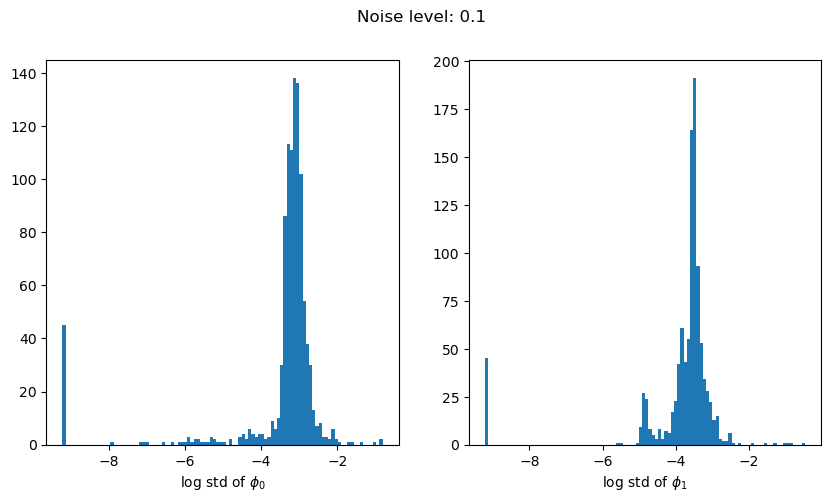

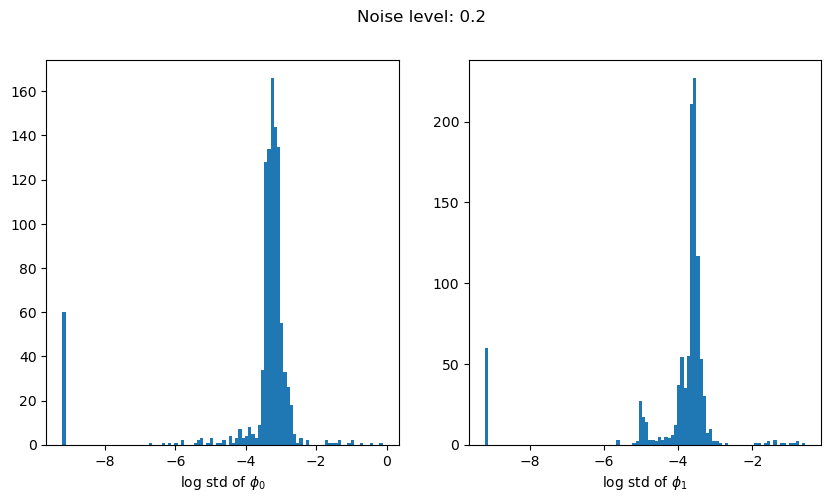

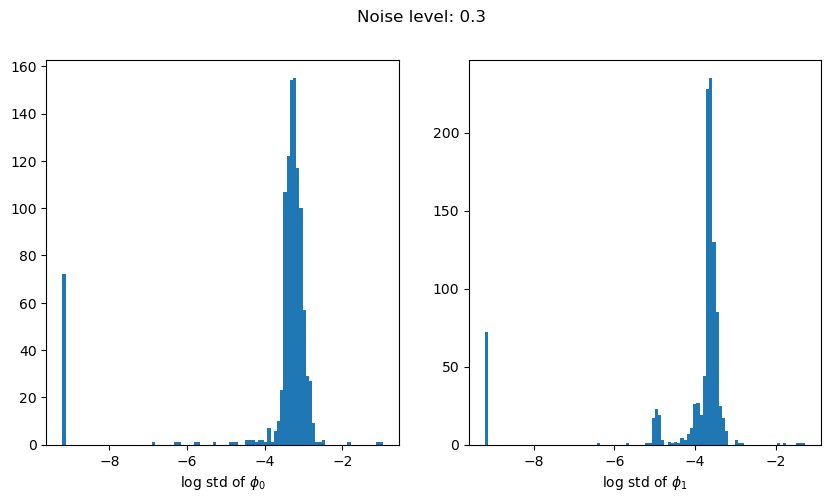

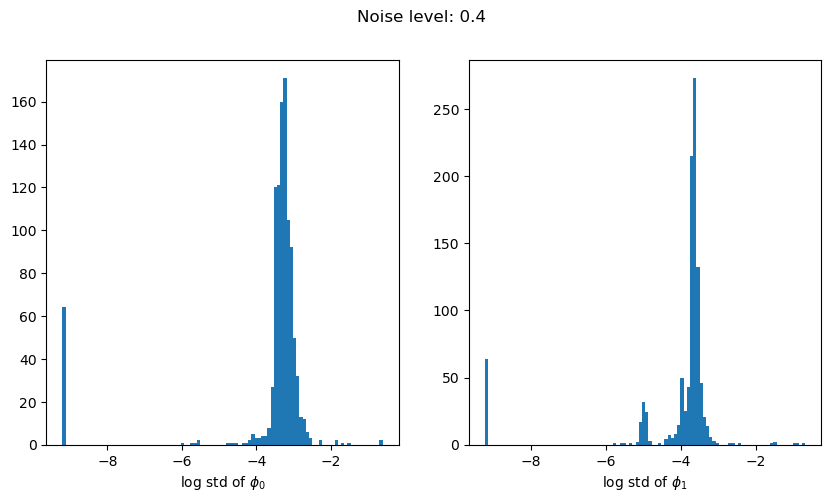

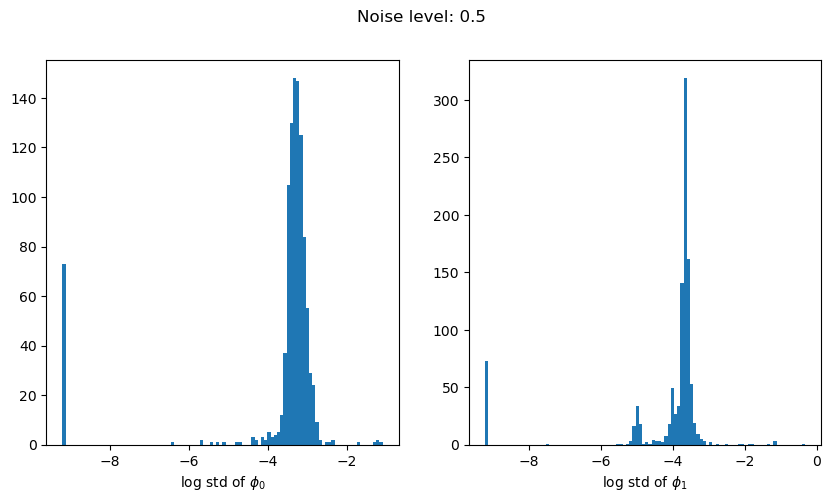

In [12]:
# Show histogram of stds
eps = 1e-4
for noise_level in noise_levels:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps), bins=100)
    axs[0].set_xlabel("log std of $\phi_0$")
    axs[1].hist(torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps), bins=100)
    axs[1].set_xlabel("log std of $\phi_1$")
    plt.suptitle("Noise level: " + str(noise_level))
    plt.show()

In [14]:
# Remove chains that have not converged

threshold = -7
converged_indices = {}
not_converged_indices = {}
for noise_level in noise_levels:
    print("Noise level:", noise_level)
    converged_indices[noise_level] = torch.where(torch.logical_or(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps) >= threshold,
                                                    torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps) >= threshold))[0]
    not_converged_indices[noise_level] = torch.where(torch.logical_and(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps) < threshold,
                                                        torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps) < threshold))[0]
    print("Number of chains that have not converged:", not_converged_indices[noise_level].shape[0])

Noise level: 0.1
Number of chains that have not converged: 45
Noise level: 0.2
Number of chains that have not converged: 60
Noise level: 0.3
Number of chains that have not converged: 72
Noise level: 0.4
Number of chains that have not converged: 64
Noise level: 0.5
Number of chains that have not converged: 73


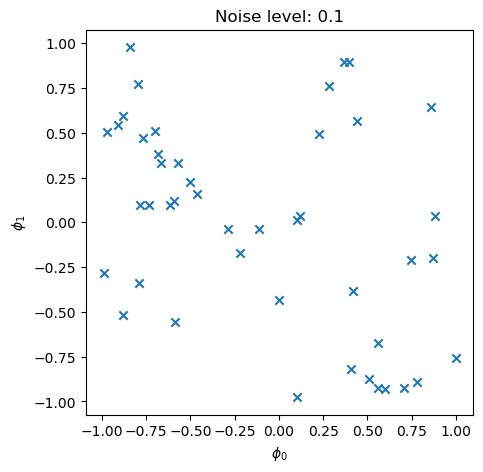

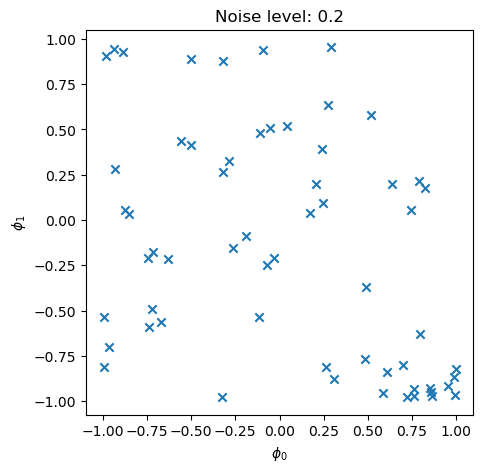

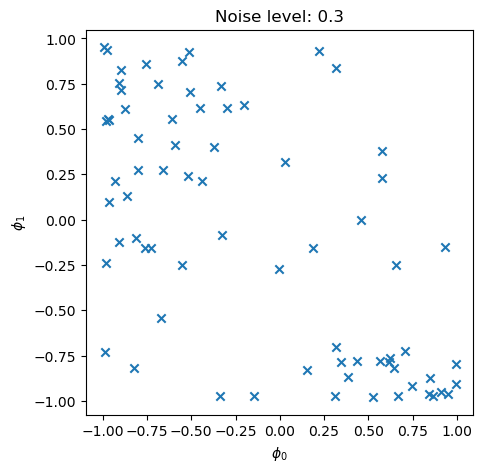

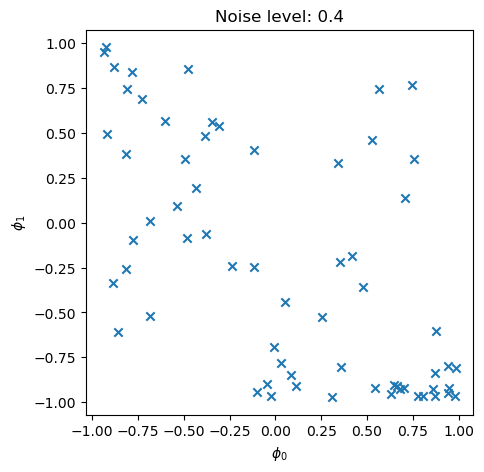

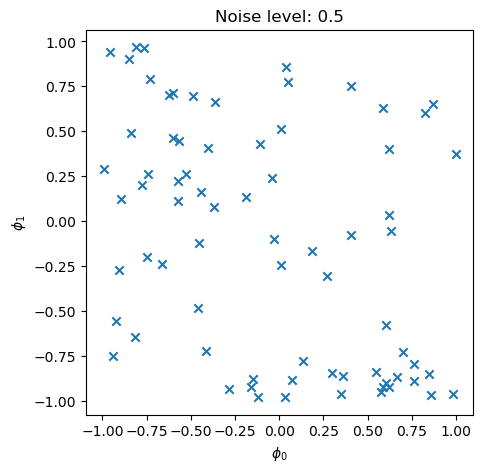

In [15]:
# Plot parameters for the chains that have not converged
for noise_level in noise_levels:
    plt.figure(figsize=(5, 5))
    plt.scatter(phi_truth_all[noise_level][not_converged_indices[noise_level], 0],
                phi_truth_all[noise_level][not_converged_indices[noise_level], 1],
                marker='x')
    plt.xlabel("$\phi_0$")
    plt.ylabel("$\phi_1$")
    plt.title("Noise level: " + str(noise_level))
    plt.show()

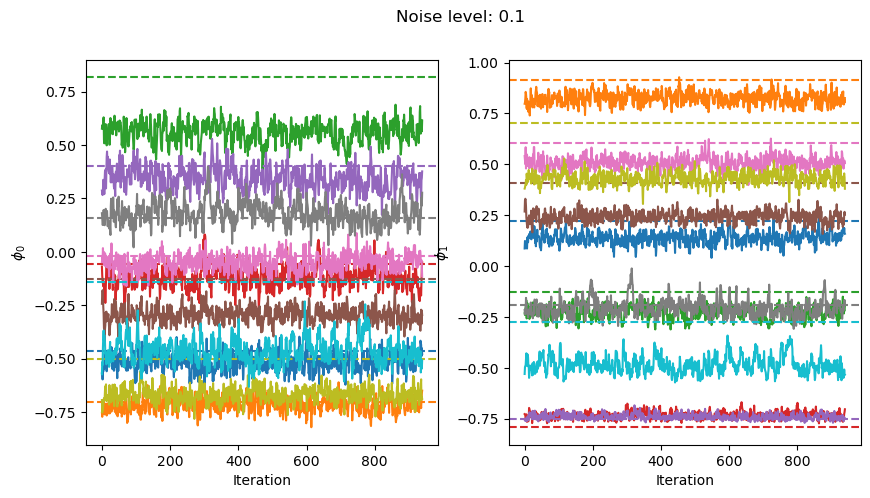

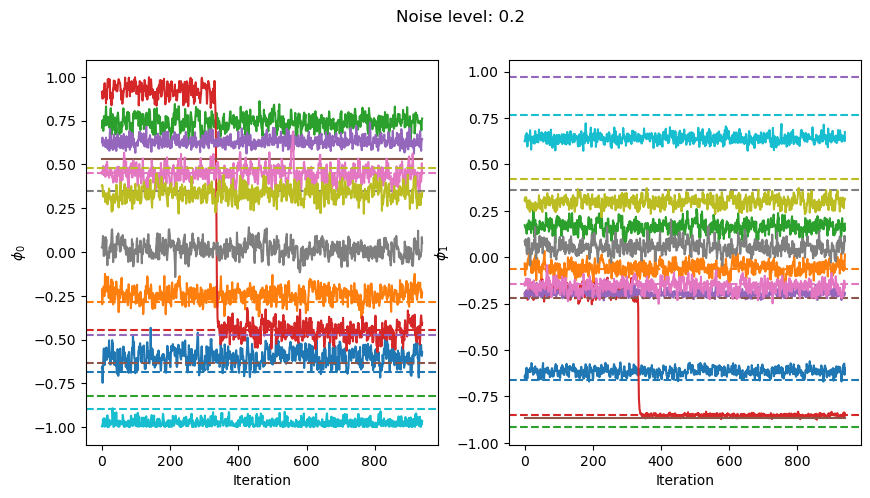

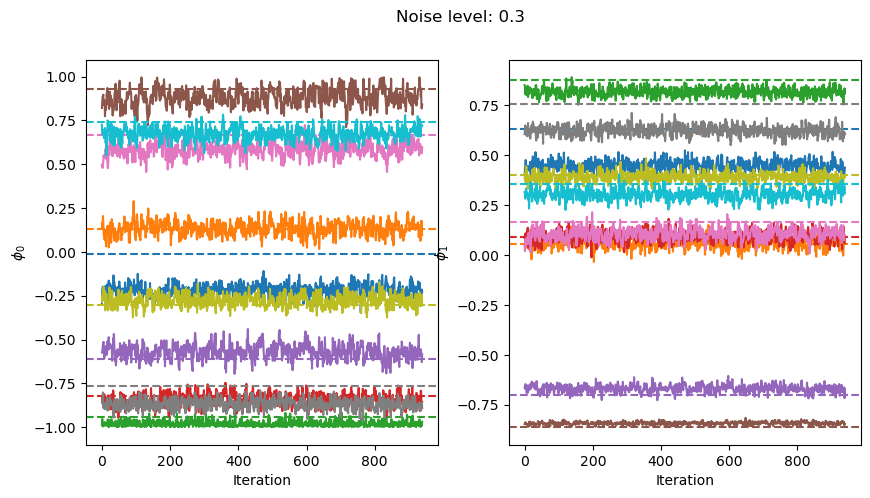

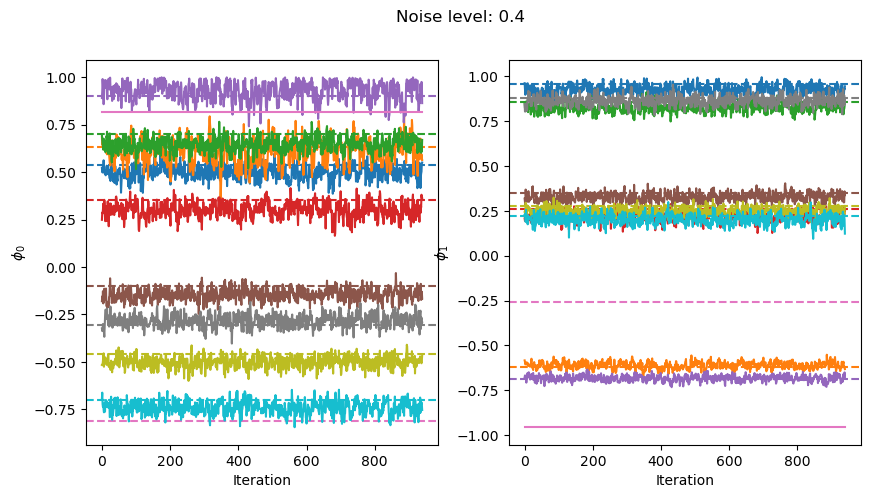

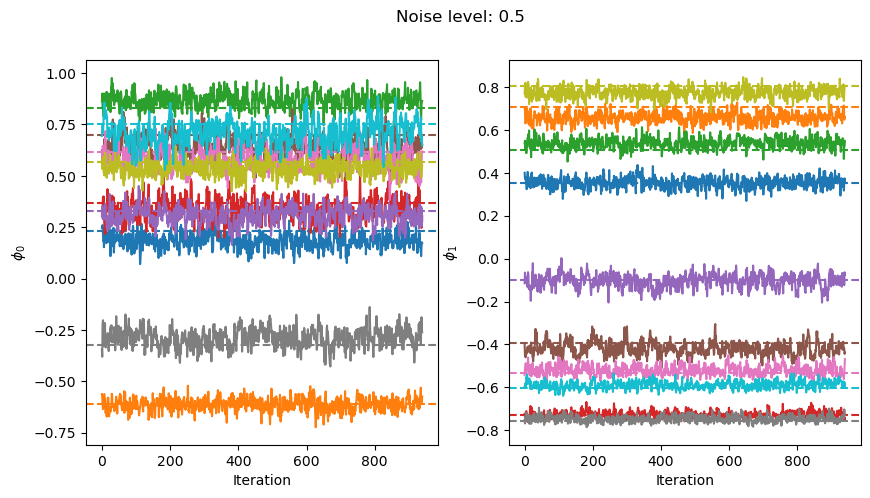

In [16]:
# Plot randomly selected chains
nb_plot_chains = 10

for noise_level in noise_levels:

    plot_indices = torch.randperm(phi_samples_all[noise_level].shape[1])[:nb_plot_chains]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(nb_plot_chains):
        axs[0].plot(phi_samples_all[noise_level][:, plot_indices[i], 0], color=f'C{i}')
        axs[0].axhline(phi_truth_all[noise_level][plot_indices[i], 0], color=f'C{i}', linestyle='--')
        axs[1].plot(phi_samples_all[noise_level][:, plot_indices[i], 1], color=f'C{i}')
        axs[1].axhline(phi_truth_all[noise_level][plot_indices[i], 1], color=f'C{i}', linestyle='--')
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("$\phi_0$")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("$\phi_1$")
    plt.suptitle("Noise level: " + str(noise_level))
    plt.show()

In [22]:
# Compute rank statistics
ranks = {}
for noise_level in noise_levels:
    phi_truth_all_converged = phi_truth_all[noise_level][converged_indices[noise_level], :]
    phi_samples_all_converged = phi_samples_all[noise_level][:, converged_indices[noise_level], :]
    ranks[noise_level] = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
    autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
    for i in range(phi_truth_all_converged.shape[0]):
        az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
        for j in range(phi_truth_all_converged.shape[1]):
            autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
            ranks[noise_level][i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

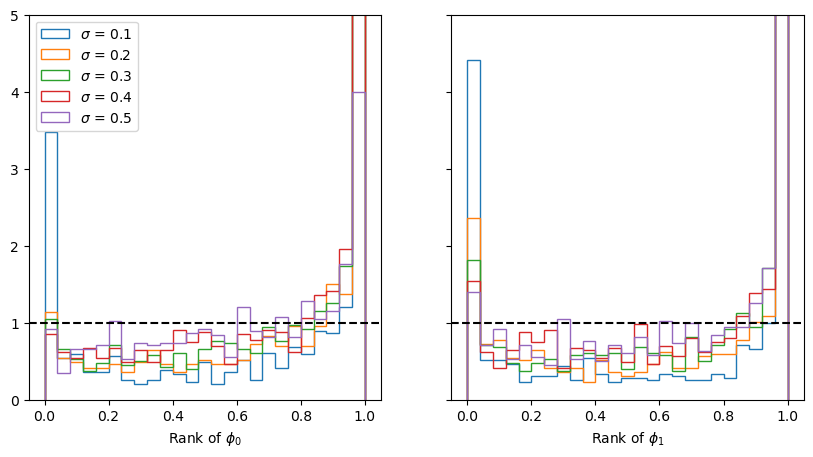

In [25]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for noise_level in noise_levels:
    axs[0].hist(ranks[noise_level][:, 0], bins=25, density=True, histtype='step', label=f"$\sigma$ = {noise_level}")
    axs[1].hist(ranks[noise_level][:, 1], bins=25, density=True, histtype='step')
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[0].legend()
axs[0].set_ylim([0, 5])
plt.show()